In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [5]:
def ternary_plot(data,
                 title = '',
                 labels = ('R', 'P', 'S'),
                 sides = 3,
                 start_angle = 90,
                 fig_args = {'figsize':(18,18),'facecolor':'white','edgecolor':'white'},
                 edge_args = {'color':'black','linewidth':2},
                 line_color = (0, 0, 0),
                 rotate_labels = False,
                 label_offset = 0.10,
                 scaling = False,
                 show = True
):
    
    basis = np.array([
        [
            np.cos(2*x*np.pi/sides + start_angle*np.pi/180),
            np.sin(2*x*np.pi/sides + start_angle*np.pi/180)
        ] for x in range(sides)
    ])
    
    if scaling:# If data is Nxsides, newdata is Nx2.
        newdata = np.dot(data.div(data.sum(axis=1), axis=0),basis)# Scales data for you.
    else:
        newdata = np.dot(data,basis)# Assumes data already sums to 1.
    
    if  not show:
        return newdata
        
    fig = plt.figure(**fig_args)
    ax = fig.add_subplot(111)
    ax.text(-0.5, 0.3, title, rotation=60, horizontalalignment='center', verticalalignment='center', size=34)
    
    for i,l in enumerate(labels):
        if i >= sides:
            break
        
        x = basis[i,0]
        y = basis[i,1]
        if rotate_labels:
            angle = 180 * np.arctan(y/x)/np.pi + 90
            if angle > 90 and angle <= 270:
                angle = np.mod(angle + 180, 360)
        else:
            angle = 0
        
        ax.text(
            x * (1 + label_offset),
            y * (1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle,
            size=34
        )
        
    # clear normal axes
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)
    
    # plot border
    ax.plot(
        [ basis[x,0] for x in list(range(sides)) + [0,] ],
        [ basis[x,1] for x in list(range(sides)) + [0,] ],
        **edge_args
    )
    
    # extra room for labels
    ax.set_xlim(left=-1.2, right=1.2)
    ax.set_ylim(bottom=-1.2, top=1.2)
    
    # plot
    end = len(newdata[:,0]) - 1
    for i in range(0,end):
        ax.plot(newdata[:,0][i:i+2], newdata[:,1][i:i+2], '.-', linewidth=2, alpha=0.99, c=(0, i / end, i / end))
    # ax.plot(newdata[:,0], newdata[:,1], linewidth=2, alpha=0.99, c='#00ff00')
    
    # fig.show()

In [6]:
def plot_df(df,
              start=0,
              end=-1, # if end < start, take everything from start upwards
              sep=',',
              size=(18,5),
              title='Average Genome',
              headers=['Avg Rock Genome','Avg Paper Genome','Avg Scissor Genome'],
              colors=['grey', 'green', 'orange'],
              line_width=2,
              scaling=False,
              plot_cartesian=False):
    if end < start:
        end = len(df)
    
    if start > 0 or end < len(df):
        df = df[start:end]
    
    ternary_plot(df[headers], scaling=scaling, title=title)
    
    if plot_cartesian:
        plt.figure(figsize=size)
        for i in range(0, len(headers)):
            plt.plot(df['Generation'], df[headers[i]], color=colors[i], linewidth=line_width, label=headers[i])

        plt.xlabel('Generation')
        plt.ylabel('Probability')
        plt.title(title)
        plt.legend()
        plt.show()

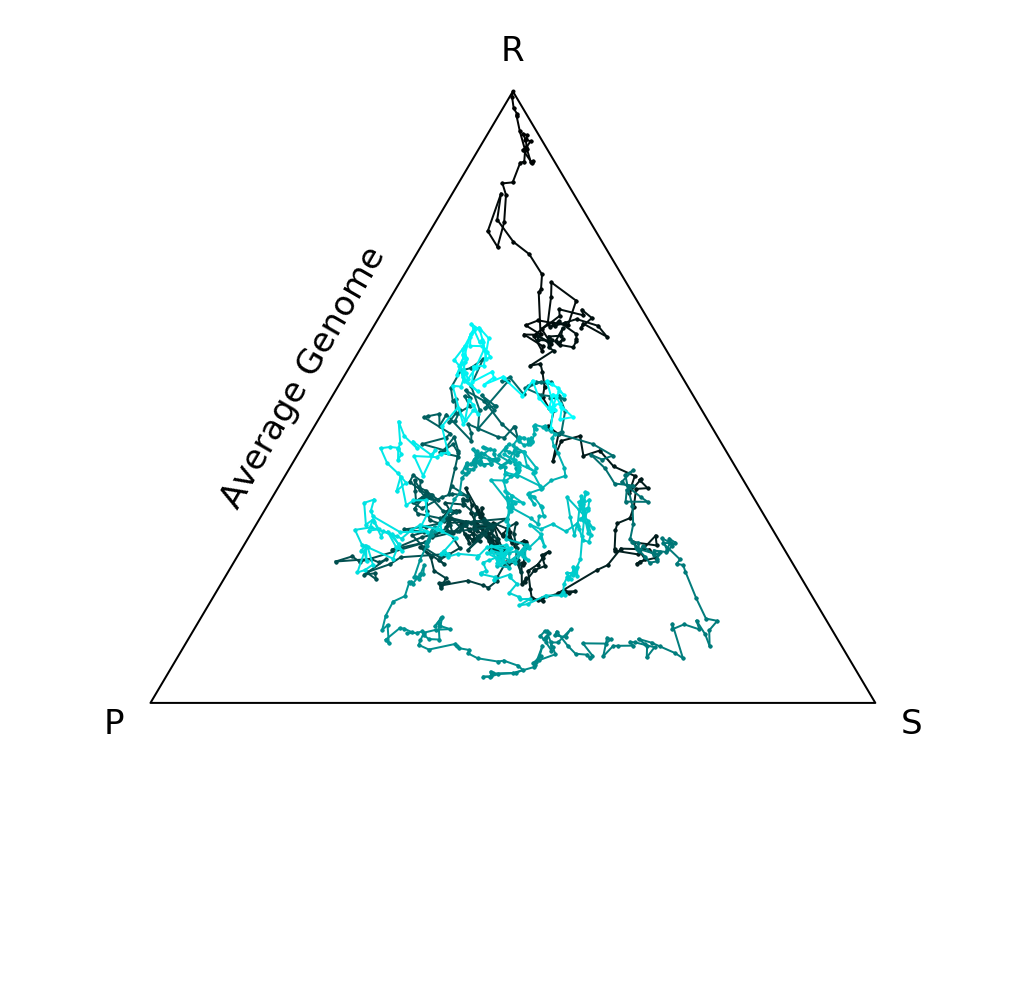

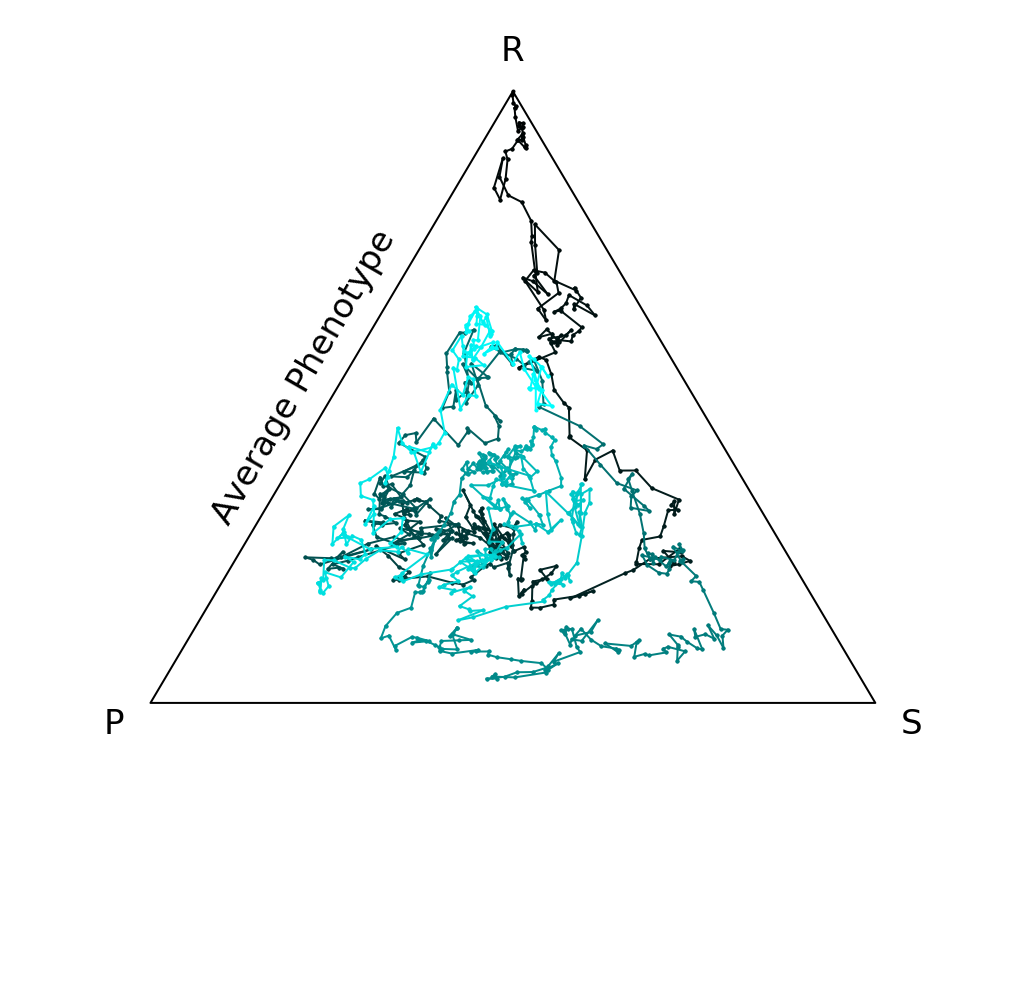

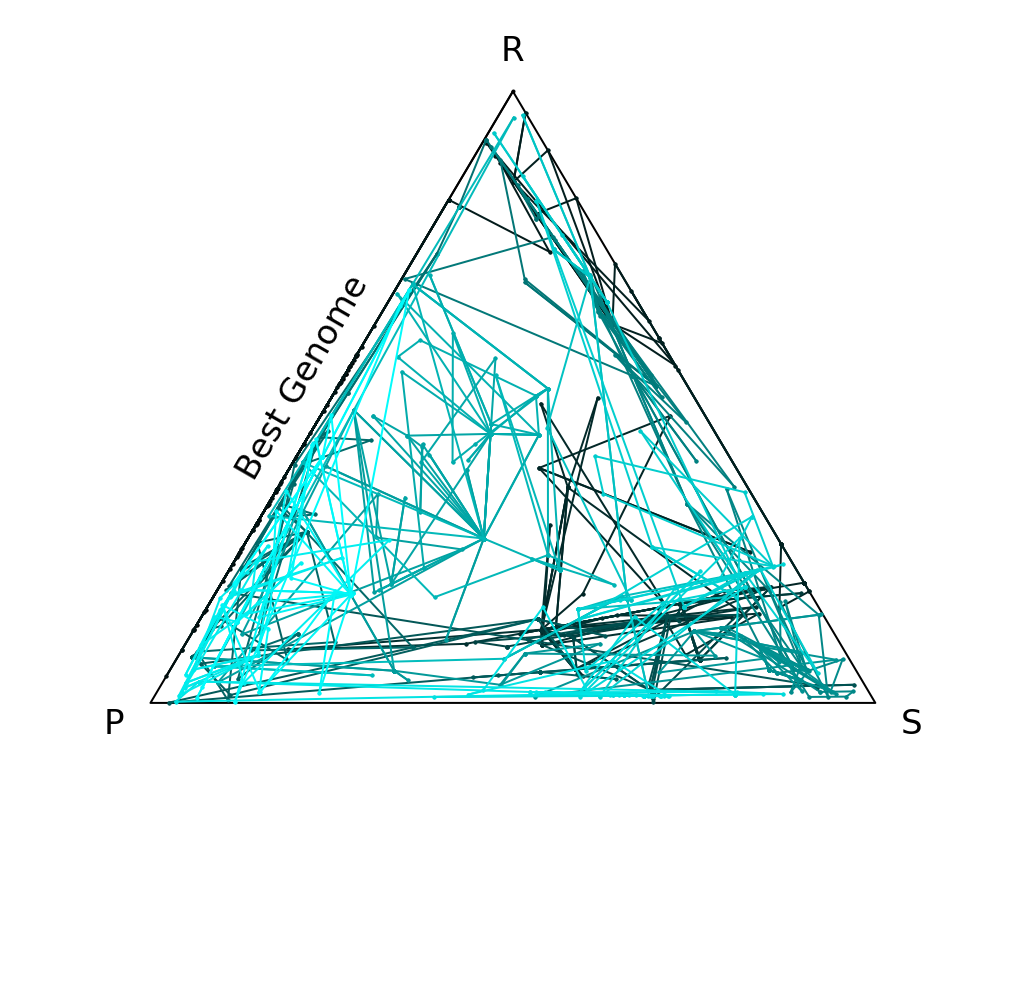

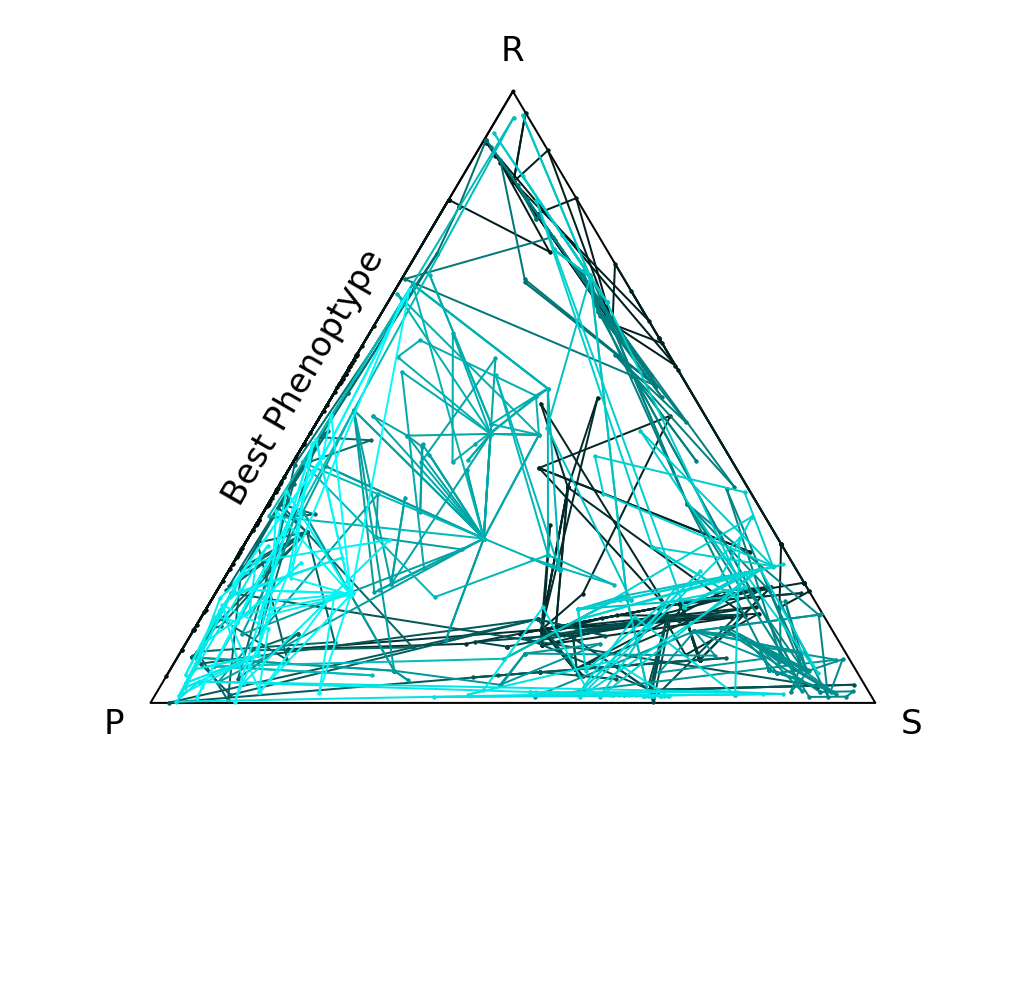

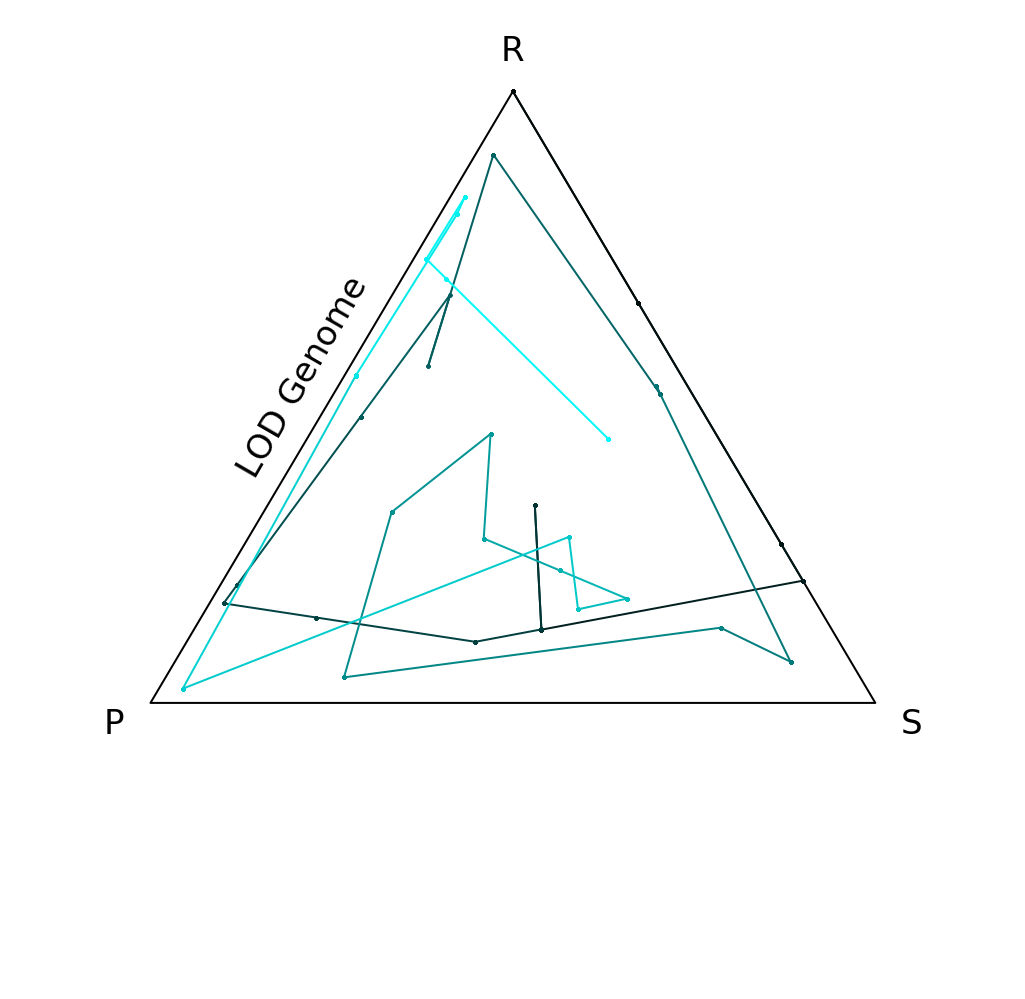

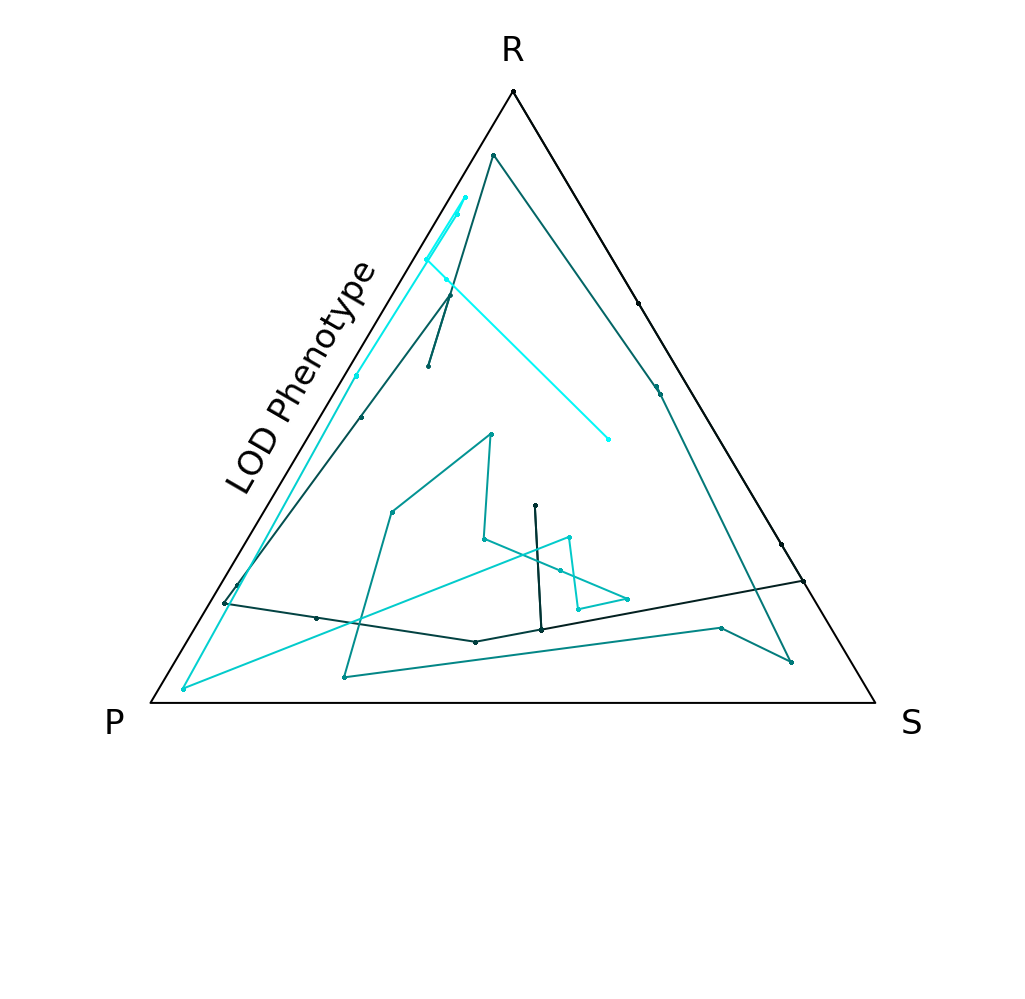

In [7]:
df = pd.read_csv('csvs/result.csv', sep=',')
headers = list(df)

titles = ['Average Genome', 'Average Phenotype', 'Best Genome', 'Best Phenoptype', 'LOD Genome', 'LOD Phenotype']

scaling = True
for x in range(0, int((len(headers)-1) / 3)):
    plot_df(df, scaling=scaling, title=titles[x], headers=headers[x*3+1:x*3+4])
    scaling = !scaling